In [66]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col, lit
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [67]:

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Clustering Véhicules") \
    .enableHiveSupport() \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .getOrCreate()
print("Session Spark initialisée avec succès.")
spark.sql("USE concessionnaire")

# Charger les données
catalogue_df = spark.sql("SELECT * FROM catalogue_co2_merge_processed")
print(f"Nombre de lignes dans le DataFrame initial : {catalogue_df.count()}")
catalogue_df.show(5, truncate=False)

Session Spark initialisée avec succès.
Nombre de lignes dans le DataFrame initial : 275
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|marque    |modele |modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix   |bonus_malus|rejets_co2|cout_energie|rejets_co2_group|
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|renault   |laguna |2.0T         |170.0              |longue  |5       |5       |gris   |true    |19110.0|-6000.0    |0.0       |206.0       |0               |
|kia       |picanto|1.1          |65.0               |courte  |5       |5       |bleu   |false   |8990.0 |-6000.0    |15.5      |132.8       |15              |
|peugeot   |1007   |1.4          |75.0               |courte  |5       |5       |bleu   |true    |9625.0 |-6000.

In [68]:

# Étape 1 : Préparation des données pour le clustering
numerical_cols = ['prix', 'unified_horse_power', 'rejets_co2', 'bonus_malus', 'nbplaces', 'nbportes']
clustering_df = catalogue_df.select(
    *[col(c).cast('double').alias(c) for c in numerical_cols],
    'marque', 'modele'
).fillna({c: 0 for c in numerical_cols})

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features_raw')
assembled_df = assembler.transform(clustering_df)

scaler = MinMaxScaler(inputCol='features_raw', outputCol='features')
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

print("Données normalisées prêtes pour le clustering :")
scaled_df.select("features").show(5, truncate=False)

Données normalisées prêtes pour le clustering :
+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|[0.12377398720682303,0.25442477876106195,0.0,0.0,0.0,1.0]                 |
|[0.015884861407249467,0.022123893805309734,0.0905373831775701,0.0,0.0,1.0]|
|[0.0226545842217484,0.04424778761061947,0.07476635514018692,0.0,0.0,1.0]  |
|(6,[0,2],[0.050106609808102345,0.07768691588785048])                      |
|[0.11332622601279317,0.17920353982300885,1.0,0.9999999999999999,0.0,1.0]  |
+--------------------------------------------------------------------------+
only showing top 5 rows


In [69]:

# Étape 2 : Clustering avec K-Means
k = 9
kmeans = KMeans(featuresCol='features', k=k, seed=1)
model = kmeans.fit(scaled_df)
clustered_df = model.transform(scaled_df)

In [70]:

# Calcul du score de silhouette
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Score de silhouette pour k={k}: {silhouette_score:.4f}")

Score de silhouette pour k=9: 0.8405


In [71]:

# Étape 3 : Analyse des clusters
print("\n--- Répartition des clusters ---")
clustered_df.groupBy('prediction').count().orderBy('prediction').show()

print("\n--- Statistiques des clusters ---")
cluster_stats = clustered_df.groupBy('prediction').agg(
    F.count('*').alias('count'),
    *[F.mean(c).alias(f'mean_{c}') for c in numerical_cols],
    *[F.stddev(c).alias(f'stddev_{c}') for c in numerical_cols]
)
cluster_stats.show(truncate=False)


--- Répartition des clusters ---
+----------+-----+
|prediction|count|
+----------+-----+
|         0|   10|
|         1|  125|
|         2|   25|
|         3|   10|
|         4|   10|
|         5|   25|
|         6|   20|
|         7|   40|
|         8|   10|
+----------+-----+


--- Statistiques des clusters ---
+----------+-----+---------+------------------------+------------------+------------------+-------------+-------------+------------------+--------------------------+------------------+------------------+---------------+---------------+
|prediction|count|mean_prix|mean_unified_horse_power|mean_rejets_co2   |mean_bonus_malus  |mean_nbplaces|mean_nbportes|stddev_prix       |stddev_unified_horse_power|stddev_rejets_co2 |stddev_bonus_malus|stddev_nbplaces|stddev_nbportes|
+----------+-----+---------+------------------------+------------------+------------------+-------------+-------------+------------------+--------------------------+------------------+------------------+--------


--- Réduction de dimensions avec PCA ---


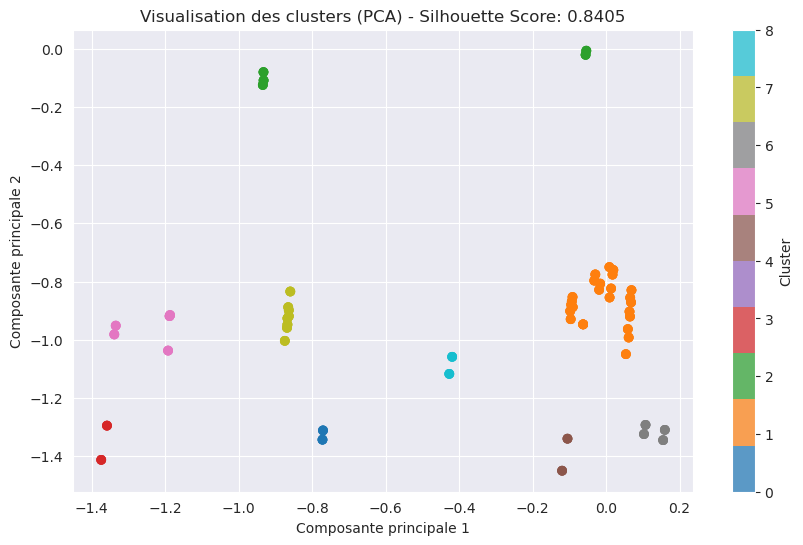

In [72]:

# Étape 4 : Réduction de dimensions pour visualisation
print("\n--- Réduction de dimensions avec PCA ---")
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

# Collecte des données pour Matplotlib
pca_data = pca_df.select("pca_features", "prediction").rdd.map(
    lambda row: (row["pca_features"][0], row["pca_features"][1], row["prediction"])
).collect()

x_coords = [x[0] for x in pca_data]
y_coords = [x[1] for x in pca_data]
predictions = [x[2] for x in pca_data]

# Visualisation des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_coords, y_coords, c=predictions, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title(f"Visualisation des clusters (PCA) - Silhouette Score: {silhouette_score:.4f}")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

In [73]:
# Étape 5 : Vérification des catégories
print("\n--- Exemples pour chaque cluster ---")
categories = clustered_df.select("prediction").distinct().rdd.flatMap(lambda x: x).collect()
for cluster in categories:
    print(f"\n--- Exemples pour le cluster {cluster} ---")
    clustered_df.filter(col("prediction") == cluster).select(
        "marque", "modele", "prix", "unified_horse_power", "rejets_co2", "bonus_malus","nbplaces", "nbportes"
    ).show(5, truncate=False)


--- Exemples pour chaque cluster ---

--- Exemples pour le cluster 1 ---
+----------+----------+-------+-------------------+----------+-----------+--------+--------+
|marque    |modele    |prix   |unified_horse_power|rejets_co2|bonus_malus|nbplaces|nbportes|
+----------+----------+-------+-------------------+----------+-----------+--------+--------+
|renault   |laguna    |19110.0|170.0              |0.0       |-6000.0    |5.0     |5.0     |
|kia       |picanto   |8990.0 |65.0               |15.5      |-6000.0    |5.0     |5.0     |
|peugeot   |1007      |9625.0 |75.0               |12.8      |-6000.0    |5.0     |5.0     |
|renault   |megane    |22350.0|135.0              |0.0       |-6000.0    |5.0     |5.0     |
|volkswagen|new beatle|26630.0|110.0              |13.3      |-6000.0    |5.0     |5.0     |
+----------+----------+-------+-------------------+----------+-----------+--------+--------+
only showing top 5 rows


--- Exemples pour le cluster 6 ---
+----------+------+-------+-

In [74]:
clustered_df.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  125|
|         6|   20|
|         3|   10|
|         5|   25|
|         4|   10|
|         8|   10|
|         2|   25|
|         7|   40|
|         0|   10|
+----------+-----+


In [75]:
model_path = "hdfs://namenode:9000/models/kmeans_modelk9"
model.write().overwrite().save(model_path)
print(f"Modèle K-Means sauvegardé dans HDFS : {model_path}")

Modèle K-Means sauvegardé dans HDFS : hdfs://namenode:9000/models/kmeans_modelk9


In [76]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, lower, trim, coalesce
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as skPCA

In [77]:
# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Clustering Véhicules") \
    .enableHiveSupport() \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .getOrCreate()
print("Session Spark initialisée avec succès.")
spark.sql("USE concessionnaire")

# Charger les données d'entraînement et les nouvelles données
training_data = spark.sql("SELECT * FROM catalogue_co2_merge_processed")
new_data_df = spark.sql("SELECT * FROM client_immatriculation_merged")

print(f"Nombre de lignes dans le DataFrame d'entraînement : {training_data.count()}")
training_data.show(5, truncate=False)

print(f"Nombre de lignes dans le DataFrame des nouvelles données : {new_data_df.count()}")
new_data_df.show(5, truncate=False)

Session Spark initialisée avec succès.
Nombre de lignes dans le DataFrame d'entraînement : 275
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|marque    |modele |modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix   |bonus_malus|rejets_co2|cout_energie|rejets_co2_group|
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|renault   |laguna |2.0T         |170.0              |longue  |5       |5       |gris   |true    |19110.0|-6000.0    |0.0       |206.0       |0               |
|kia       |picanto|1.1          |65.0               |courte  |5       |5       |bleu   |false   |8990.0 |-6000.0    |15.5      |132.8       |15              |
|peugeot   |1007   |1.4          |75.0               |courte  |5       |5       |bleu   |true    |9625.0 

In [78]:
# Nettoyage des données : lowercase et trim des colonnes 'marque' et 'modele'
new_data_df = new_data_df.withColumn("marque", lower(trim(col("marque"))))
new_data_df = new_data_df.withColumn("modele", lower(trim(col("modele"))))

In [79]:
# Renommer 'puissance' en 'unified_horse_power' pour correspondre au modèle entraîné
if 'puissance' in new_data_df.columns:
    new_data_df = new_data_df.withColumnRenamed("puissance", "unified_horse_power")
    print("Colonne 'puissance' renommée en 'unified_horse_power'.")
else:
    new_data_df = new_data_df.withColumn("unified_horse_power", lit(None).cast("double"))
    print("Colonne 'unified_horse_power' ajoutée avec des valeurs nulles.")

# Ajouter les colonnes manquantes avec des valeurs nulles
columns_to_check = ["prix", "rejets_co2", "bonus_malus", "nbplaces", "nbportes"]
for col_name in columns_to_check:
    if col_name not in new_data_df.columns:
        new_data_df = new_data_df.withColumn(col_name, lit(None).cast("double"))
        print(f"Colonne manquante '{col_name}' ajoutée avec des valeurs nulles.")

Colonne 'puissance' renommée en 'unified_horse_power'.
Colonne manquante 'rejets_co2' ajoutée avec des valeurs nulles.
Colonne manquante 'bonus_malus' ajoutée avec des valeurs nulles.


In [80]:
# Calcul des moyennes par modèle et par marque pour l'imputation de 'rejets_co2' et 'bonus_malus'
avg_by_model = training_data.groupBy("marque", "modele").agg(
    F.avg("rejets_co2").alias("avg_rejets_co2_model"),
    F.avg("bonus_malus").alias("avg_bonus_malus_model")
)

avg_by_marque = training_data.groupBy("marque").agg(
    F.avg("rejets_co2").alias("avg_rejets_co2_marque"),
    F.avg("bonus_malus").alias("avg_bonus_malus_marque")
)

# Joindre les moyennes par modèle et par marque aux nouvelles données
new_data_df = new_data_df.join(avg_by_model, on=["marque", "modele"], how="left")
new_data_df = new_data_df.join(avg_by_marque, on="marque", how="left")

# Vérifiez que toutes les marques et modèles dans new_data_df ont des moyennes dans training_data
missing_avg = new_data_df.filter(
    (col("avg_rejets_co2_model").isNull()) | 
    (col("avg_bonus_malus_model").isNull()) |
    (col("avg_rejets_co2_marque").isNull()) |
    (col("avg_bonus_malus_marque").isNull())
).select("marque", "modele").distinct()

if missing_avg.count() > 0:
    print("Attention : Certaines marques ou modèles n'ont pas de moyennes disponibles dans les données d'entraînement.")
    missing_avg.show(truncate=False)
    # Option : Imputer ces valeurs avec des valeurs spécifiques ou les exclure
    # Ici, nous allons les exclure pour éviter des imputations incorrectes
    new_data_df = new_data_df.filter(
        ~( (col("avg_rejets_co2_model").isNull()) |
           (col("avg_bonus_malus_model").isNull()) |
           (col("avg_rejets_co2_marque").isNull()) |
           (col("avg_bonus_malus_marque").isNull()) )
    )
    print("Les lignes avec des moyennes manquantes ont été exclues.")
else:
    print("Toutes les marques et modèles ont des moyennes disponibles.")

# Imputation de 'rejets_co2' en utilisant la moyenne par modèle, puis par marque
new_data_df = new_data_df.withColumn(
    "rejets_co2",
    when(
        (col("rejets_co2").isNotNull()) & (col("rejets_co2") > 0),
        col("rejets_co2")
    ).otherwise(
        when(
            (col("avg_rejets_co2_model").isNotNull()) & (col("avg_rejets_co2_model") > 0),
            col("avg_rejets_co2_model")
        ).otherwise(
            when(
                (col("avg_rejets_co2_marque").isNotNull()) & (col("avg_rejets_co2_marque") > 0),
                col("avg_rejets_co2_marque")
            ).otherwise(lit(None))
        )
    )
)

# Imputation de 'bonus_malus' en utilisant la moyenne par modèle, puis par marque
new_data_df = new_data_df.withColumn(
    "bonus_malus",
    when(
        (col("bonus_malus").isNotNull()) & (col("bonus_malus") > 0),
        col("bonus_malus")
    ).otherwise(
        when(
            (col("avg_bonus_malus_model").isNotNull()) & (col("avg_bonus_malus_model") > 0),
            col("avg_bonus_malus_model")
        ).otherwise(
            when(
                (col("avg_bonus_malus_marque").isNotNull()) & (col("avg_bonus_malus_marque") > 0),
                col("avg_bonus_malus_marque")
            ).otherwise(lit(None))
        )
    )
)

# Assurer que 'rejets_co2' et 'bonus_malus' sont positifs
new_data_df = new_data_df.withColumn(
    "rejets_co2",
    when(col("rejets_co2") < 0, lit(None)).otherwise(col("rejets_co2"))
).withColumn(
    "bonus_malus",
    when(col("bonus_malus") < 0, lit(None)).otherwise(col("bonus_malus"))
)

# Remplir les valeurs nulles restantes dans les colonnes numériques avec 0.0
new_data_df = new_data_df.fillna({
    "rejets_co2": 0.0,
    "bonus_malus": 0.0,
    "prix": 0.0,
    "nbplaces": 0.0,
    "nbportes": 0.0,
    "unified_horse_power": 0.0
})

# Suppression des colonnes intermédiaires
new_data_df = new_data_df.drop("avg_rejets_co2_model", "avg_bonus_malus_model",
                               "avg_rejets_co2_marque", "avg_bonus_malus_marque")

# Vérification des valeurs de 'rejets_co2' et 'bonus_malus'
print("Statistiques de 'rejets_co2' et 'bonus_malus' après imputation :")
new_data_df.select("rejets_co2", "bonus_malus").describe().show()

Attention : Certaines marques ou modèles n'ont pas de moyennes disponibles dans les données d'entraînement.
+----------+------+
|marque    |modele|
+----------+------+
|volkswagen|new   |
|volvo     |s80   |
|renault   |vel   |
+----------+------+

Les lignes avec des moyennes manquantes ont été exclues.
Statistiques de 'rejets_co2' et 'bonus_malus' après imputation :
+-------+------------------+------------------+
|summary|        rejets_co2|       bonus_malus|
+-------+------------------+------------------+
|  count|             86303|             86303|
|   mean| 56.50490481211639|1334.0136275680038|
| stddev| 57.74079785270125|2411.6459491211263|
|    min|               0.0|               0.0|
|    max|171.20000000000002|            7772.1|
+-------+------------------+------------------+


In [81]:
# Assemblage des colonnes pour VectorAssembler
numerical_cols = ["prix", "unified_horse_power", "rejets_co2", "bonus_malus", "nbplaces", "nbportes"]
assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="features_raw"
)
assembled_df = assembler.transform(new_data_df)

# Vérification de 'features_raw'
if assembled_df.filter(col("features_raw").isNull()).count() > 0:
    raise ValueError("La colonne `features_raw` contient des valeurs nulles.")
else:
    print("Toutes les lignes ont une colonne `features_raw` valide.")

# Normalisation des données
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(assembled_df)
normalized_df = scaler_model.transform(assembled_df)

# Vérification des données normalisées
print("Exemples de données normalisées :")
normalized_df.select("features").show(5, truncate=False)

Toutes les lignes ont une colonne `features_raw` valide.
Exemples de données normalisées :
+--------------------------------------------------------------------------------------+
|features                                                                              |
+--------------------------------------------------------------------------------------+
|[0.9307036247334755,1.0,0.22605140186915884,0.0,0.5,1.0]                              |
|[0.258955223880597,0.3053097345132743,0.1810747663551402,0.0,0.5,1.0]                 |
|[0.20810234541577824,0.21017699115044247,0.709696261682243,0.3287013805792514,0.5,1.0]|
|[0.9307036247334755,1.0,0.22605140186915884,0.0,0.5,1.0]                              |
|[0.06663113006396588,0.04424778761061947,0.07476635514018691,0.0,0.5,1.0]             |
+--------------------------------------------------------------------------------------+
only showing top 5 rows


In [82]:

# Chargement du modèle K-Means pré-entraîné
model_path = "hdfs://namenode:9000/models/kmeans_modelk9"
try:
    kmeans_model = KMeansModel.load(model_path)
    print("Modèle K-Means chargé avec succès.")
except Exception as e:
    raise ValueError(f"Erreur lors du chargement du modèle K-Means : {e}")

# # Appliquer le modèle pour prédire les clusters
predicted_df = kmeans_model.transform(normalized_df)
print("Prédictions des clusters effectuées avec succès.")
predicted_df.select("prediction").show(5)

# Ajouter des catégories basées sur les prédictions
predicted_df = predicted_df.withColumn(
    "categorie",
    when(col("prediction") == 0, "Citadines compactes puisantes") 
    .when(col("prediction") == 1, "Micro Citadines")
    .when(col("prediction") == 2, "Citadines économiques")
    .when(col("prediction") == 3, "Berlines puisantes de luxe")
    .when(col("prediction") == 4, "Voitures sportives haut de gamme")
    .when(col("prediction") == 5, "Citadines économiques")
    .when(col("prediction") == 6, "Berlines de luxe") 
    .when(col("prediction") == 7, "Citadines")
    .when(col("prediction") == 8, "Berlines hybrides haut de gamme")
    .otherwise("Autres")
)
print("Catégories assignées en fonction des prédictions.")
predicted_df.select("prediction", "categorie").distinct().show()

# Vérification des catégories avec des exemples
categories = predicted_df.select("categorie").distinct().rdd.flatMap(lambda x: x).collect()
for cat in categories:
    print(f"\n--- Exemples pour la catégorie : {cat} ---")
    predicted_df.filter(col("categorie") == cat).select(
        "marque", "modele", "prix", "rejets_co2", "bonus_malus",
        "nbplaces", "nbportes", "unified_horse_power", "categorie"
    ).show(5, truncate=False)



Modèle K-Means chargé avec succès.
Prédictions des clusters effectuées avec succès.
+----------+
|prediction|
+----------+
|         4|
|         1|
|         7|
|         4|
|         1|
+----------+
only showing top 5 rows

Catégories assignées en fonction des prédictions.
+----------+--------------------+
|prediction|           categorie|
+----------+--------------------+
|         2|Citadines économi...|
|         4|Voitures sportive...|
|         1|     Micro Citadines|
|         7|           Citadines|
|         5|Citadines économi...|
|         3|Berlines puisante...|
|         6|    Berlines de luxe|
|         0|Citadines compact...|
+----------+--------------------+

--- Exemples pour la catégorie : Berlines puisantes de luxe ---
+--------+------+--------+------------------+-----------+--------+--------+-------------------+--------------------------+
|marque  |modele|prix    |rejets_co2        |bonus_malus|nbplaces|nbportes|unified_horse_power|categorie                 |
+----

In [83]:
# Affichage des résultats finaux
predicted_df.select("marque", "modele", *numerical_cols, "unified_horse_power", "prediction", "categorie").show(5, truncate=False)

+-------+------+-------+-------------------+------------------+------------------+--------+--------+-------------------+----------+--------------------------------+
|marque |modele|prix   |unified_horse_power|rejets_co2        |bonus_malus       |nbplaces|nbportes|unified_horse_power|prediction|categorie                       |
+-------+------+-------+-------------------+------------------+------------------+--------+--------+-------------------+----------+--------------------------------+
|bmw    |m5    |94800.0|507                |38.699999999999996|0.0               |5       |5       |507                |4         |Voitures sportives haut de gamme|
|skoda  |superb|31790.0|193                |31.0              |0.0               |5       |5       |193                |1         |Micro Citadines                 |
|saab   |9.3   |27020.0|150                |121.5             |2554.7000000000003|5       |5       |150                |7         |Citadines                       |
|bmw    |m

In [84]:
# Sélectionner les colonnes pertinentes à sauvegarder
final_df = predicted_df
# Sauvegarder dans une nouvelle table Hive
final_df.write.mode("overwrite").saveAsTable("client_immat_with_catk9")
print("Les résultats du clustering ont été sauvegardés dans la table Hive 'client_immat_with_catk9'.")


Les résultats du clustering ont été sauvegardés dans la table Hive 'client_immat_with_catk9'.


In [85]:
spark.sql("SELECT * FROM client_immat_with_catk9").show(15, truncate=False)

+----------+------+---------------+---+-----+----+-------------------+---------------+---------------+-------------------+-----------+--------+--------+-------+--------+--------+------------------+------------------+--------------------------------------------------+--------------------------------------------------------------------------------------+----------+--------------------------------+
|marque    |modele|immatriculation|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|unified_horse_power|longueur   |nbplaces|nbportes|couleur|occasion|prix    |rejets_co2        |bonus_malus       |features_raw                                      |features                                                                              |prediction|categorie                       |
+----------+------+---------------+---+-----+----+-------------------+---------------+---------------+-------------------+-----------+--------+--------+-------+--------+--------+------------------+-----


--- Visualisation des clusters avec PCA ---


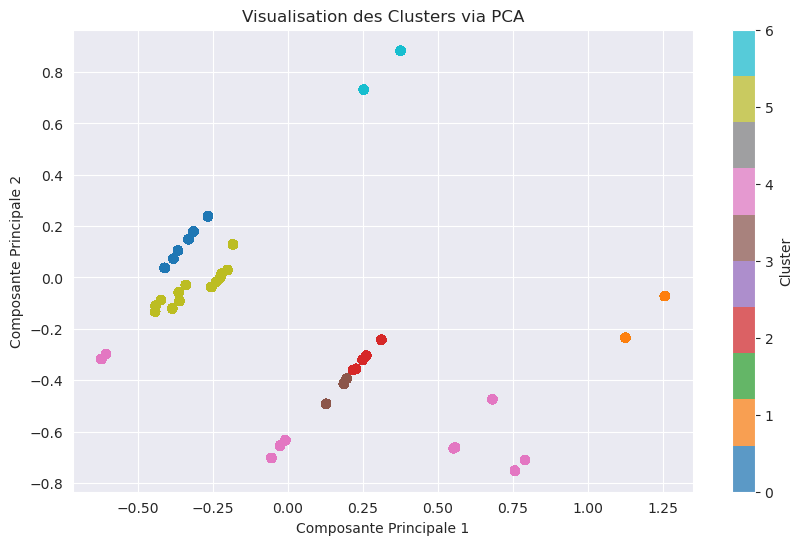


--- Visualisation des centroïdes ---


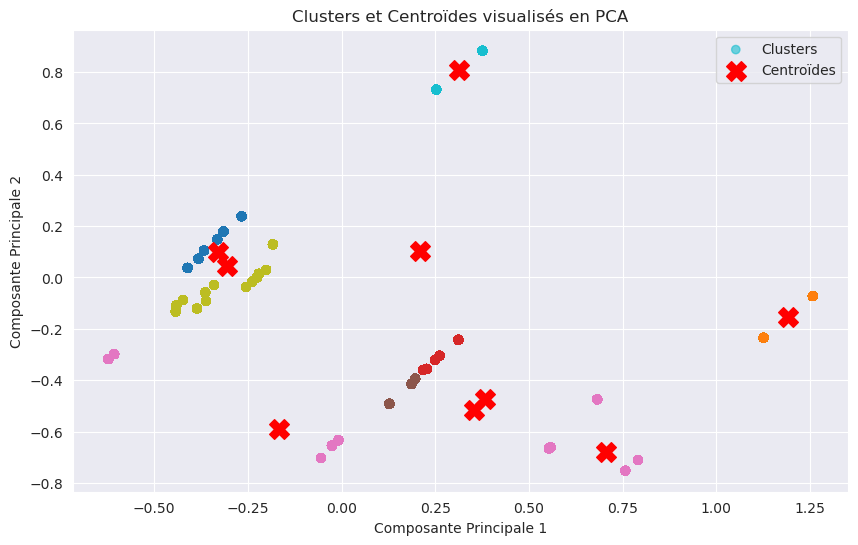

In [86]:
# Visualisation des clusters avec PCA
print("\n--- Visualisation des clusters avec PCA ---")
# Conversion du DataFrame Spark en DataFrame Pandas pour PCA
pca_data = predicted_df.select("features", "categorie").toPandas()

# Conversion des vecteurs Spark MLlib en listes pour sklearn PCA
pca_data['features'] = pca_data['features'].apply(lambda x: x.toArray())

# Application de PCA
pca = skPCA(n_components=2)
pca_result = pca.fit_transform(pca_data['features'].tolist())

# Ajout des composantes principales au DataFrame Pandas
pca_data['PC1'] = pca_result[:, 0]
pca_data['PC2'] = pca_result[:, 1]

# Ajout de la colonne 'categorie'
pca_data['categorie'] = predicted_df.select("categorie").toPandas()['categorie']

# Tracé des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_data['PC1'], pca_data['PC2'],
    c=pca_data['categorie'].astype('category').cat.codes,
    cmap="tab10", alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualisation des Clusters via PCA")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.grid(True)
plt.show()

# Tracé des centroïdes
print("\n--- Visualisation des centroïdes ---")
# Récupérer les centroïdes du modèle K-Means
centroids = kmeans_model.clusterCenters()

# Appliquer PCA sur les centroïdes
centroids_pca = pca.transform(centroids)

# Tracé des clusters et des centroïdes
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_data['PC1'], pca_data['PC2'],
    c=pca_data['categorie'].astype('category').cat.codes,
    cmap="tab10", alpha=0.6, label='Clusters'
)
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', marker='X', s=200, label='Centroïdes'
)
plt.colorbar(scatter, label="Cluster")
plt.title("Clusters et Centroïdes visualisés en PCA")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Calcul du Silhouette Score final
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette_score = evaluator.evaluate(predicted_df)
print(f"Silhouette Score avec k={kmeans_model.getK()} : {silhouette_score:.4f}")

Silhouette Score avec k=9 : 0.7645


In [88]:
spark.stop() 